In [1]:
#!/projects/jinamo@xsede.org/software/anaconda/envs/Renv/bin/Rscript

# load packages and functions
suppressMessages(library(data.table))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(ggpointdensity))
suppressMessages(library(ggrepel))
suppressMessages(library(ggsci))
suppressMessages(library(ggthemes))
suppressMessages(library(magrittr))
suppressMessages(library(patchwork))
suppressMessages(library(RColorBrewer))
suppressMessages(library(stringr))
suppressMessages(library(tidyverse))
suppressMessages(library(viridis))
suppressMessages(library(ComplexHeatmap))

selected_markers<- c("CD45",
                     "CD172ab",
                     "CD8a",
                     "CD20",
                     "CD4",
                     "CD3",
                     "CD56",
                     "GNLY",
                     "KIR2DS1",
                     "CD2",
                     "DAP12",
                     "NKG2C",
                     "SH2D1A",
                     "CD7",
                     "GZMA",
                     "GZMK",
                     "2B4",
                     "TCRVd1",
                     "PSGL-1",
                     "CD69",
                     "TCRgd",
                     "EOMES",
                     "CD8b",
                     "CD16",
                     "CD39",
                     "PLZF",
                     "NKp30",
                     "MR-1-tet",
                     "NKp80",
                     "4-1BB",
                     "CXCR6",
                     "KIR2DS2",
                     "CD107a",
                     "GZMB",
                     "NKp46",
                     "CD3z",
                     "iNKT",
                     "TCRVd2",
                     "NKG2D",
                     "TCRab",
                     "Ki67",
                     "Tbet",
                     "Perforin",
                     "CD57",
                     "HLA-DR",
                     "SLAMF6",
                     "CD38",
                     "CD11b")

# set parameters
prop = 0.1
n_min = 10000
frac = 1
n_neighbors=30
min_dist=0.01
resolution_list=0.3

# cluster annotation
cluster_df = read.table("/projects/jinamo@xsede.org/cytof/data/cluster_annotation.txt",sep="\t",header=TRUE) %>%
    dplyr::filter(cell=="ALL") %>%
    dplyr::select(-cell) %>%
    dplyr::mutate(cluster = as.character(cluster))

In [2]:
exp_ds <- readRDS(file = "/projects/jinamo@xsede.org/cytof/data/ALL/ALL_downsampled_Cells.rds")

`summarise()` has grouped output by 'subject_id__time'. You can override using
the `.groups` argument.


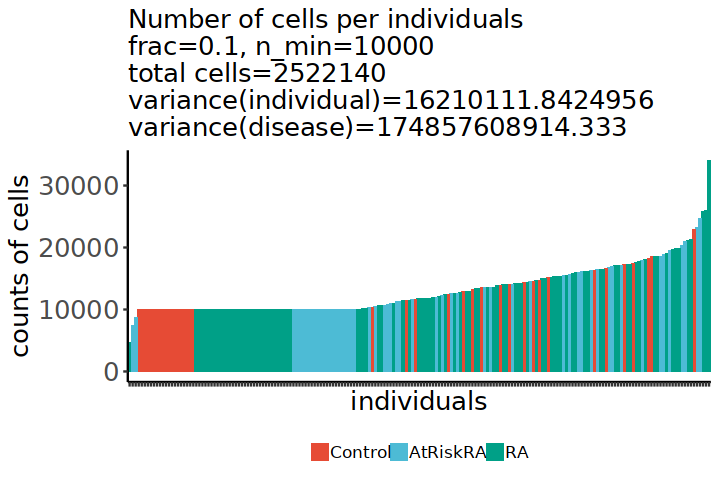

In [3]:
tmp = cbind(
  exp_ds %>%
    dplyr::group_by(subject_id__time) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::summarise(Total_cell_count=sum(cell_counts), ind_variance=var(cell_counts)),
  exp_ds %>%
    dplyr::group_by(disease) %>%
    dplyr::summarise(cell_counts = n()) %>%
    dplyr::summarise(disease_variance=var(cell_counts))
)
options(repr.plot.height = 4, repr.plot.width = 6)
exp_ds %>%
       dplyr::group_by(subject_id__time, disease) %>%
       dplyr::summarise(cell_counts = n()) %>%
       dplyr::ungroup() %>%
       dplyr::arrange(desc(cell_counts)) %>%
       ggplot() + 
       geom_bar(aes(reorder(subject_id__time,cell_counts),cell_counts, fill = disease), stat = 'identity') + 
       theme_classic() +
       scale_fill_npg() +
       # facet_grid( ~ disease) + 
       theme(strip.text.x=element_text(size=15, color="black", face="bold"),
             strip.text.y=element_text(size=15, color="black", face="bold"),
             legend.position = "bottom",
             plot.title = element_text(size=15),
             axis.title.x = element_text(size=15),
             axis.title.y = element_text(size =15),
             axis.text.y = element_text(size = 15),
             axis.text.x = element_blank(),
             legend.text =  element_text(size = 10), 
             legend.key.size = grid::unit(0.8, "lines"),
             legend.title = element_text(size = 0, hjust = 0)) +
       labs(title = paste0("Number of cells per individuals\nfrac=", prop, ", n_min=",n_min, "\ntotal cells=", tmp$Total_cell_count, "\nvariance(individual)=",tmp$ind_variance,"\nvariance(disease)=",tmp$disease_variance),
            x = 'individuals',
            y = "counts of cells") 

In [4]:
exp_ds %>%
       dplyr::group_by(disease,time_point) %>%
       dplyr::summarise(cell_counts = n())

`summarise()` has grouped output by 'disease'. You can override using the
`.groups` argument.


disease,time_point,cell_counts
<fct>,<chr>,<int>
Control,V0,489449
AtRiskRA,V0,729435
RA,V0,765398
RA,V1,274688
RA,V2,263170


[1] "B cells"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



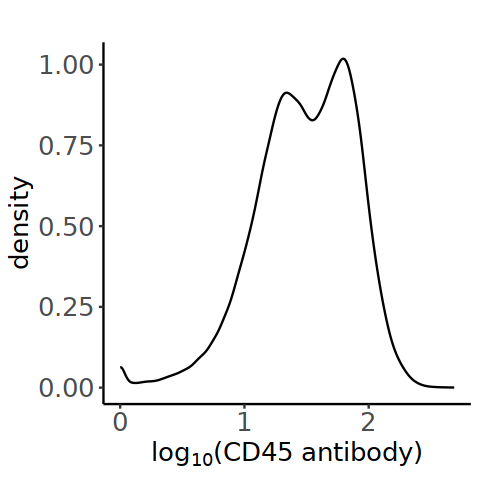

geom_pointdensity using method='kde2d' due to large number of points (>20k)



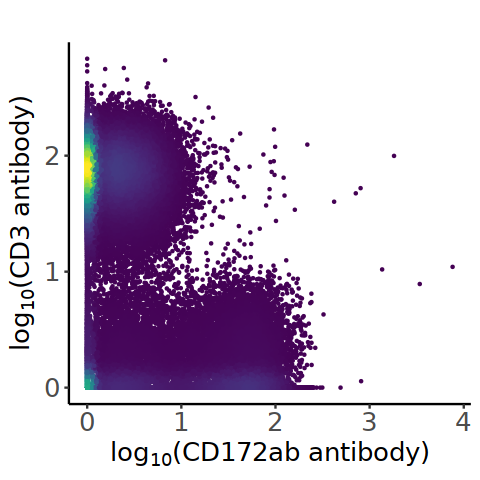

[1] "T cells and NK cells"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



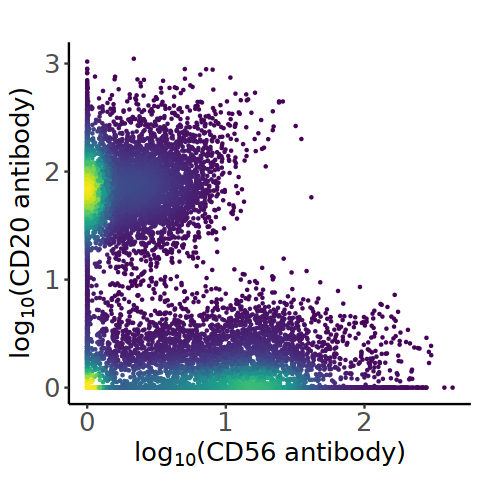

geom_pointdensity using method='kde2d' due to large number of points (>20k)



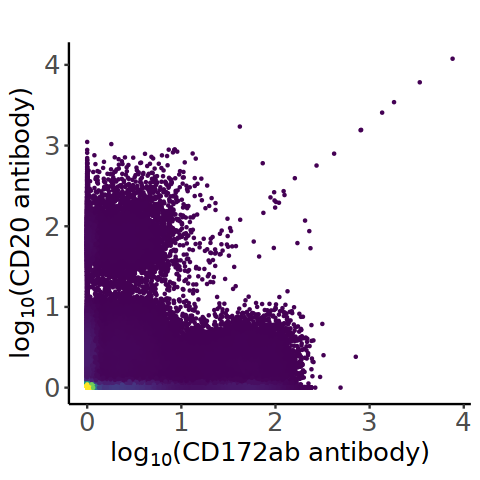

[1] "Myeloid"


geom_pointdensity using method='kde2d' due to large number of points (>20k)



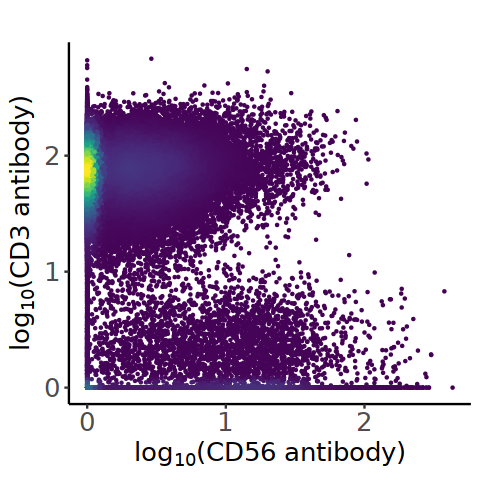

geom_pointdensity using method='kde2d' due to large number of points (>20k)



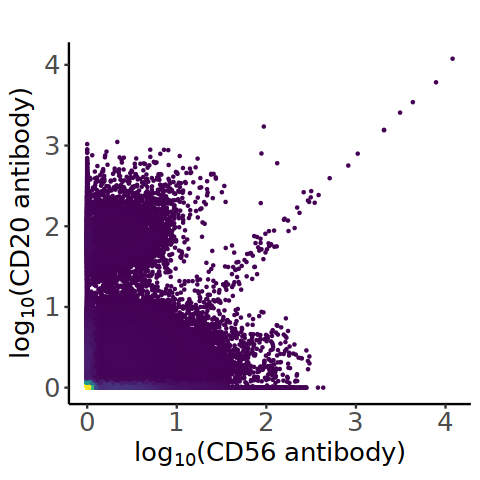

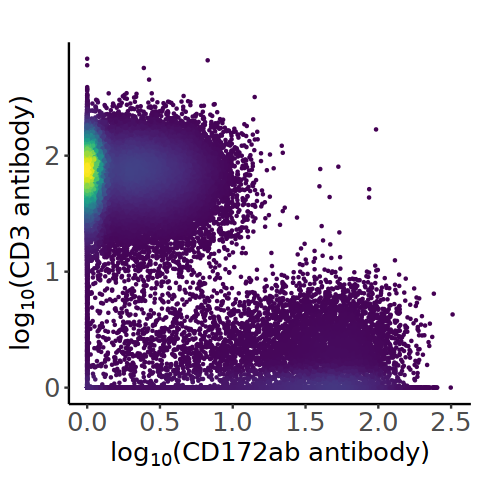

In [5]:
# manual gating

thresh_l = 0.3 #### CD45(PTPRC): Y89Di
thresh_b = 1.2 #### CD20(MS4A1): Cd113Di
thresh_m = 0.9 #### CD172ab(SIRPA): Cd111Di
thresh_t = 1.0 #### CD3: In115Di
thresh_nk = 0.3 #### CD56(NCAM1): Cd116Di
exp_test = dplyr::sample_n(exp_ds,1e05)

options(repr.plot.height = 4, repr.plot.width = 4)
xmin = 0
ymin = 0
xmax = log10(max(exp_test$Y89Di)+1)

ggplot(exp_test, aes(x=log10(Y89Di+1))) + 
                geom_density() +
                theme_classic() +
                theme(strip.text.x=element_text(size=15, color="black", face="bold"),
                      strip.text.y=element_text(size=15, color="black", face="bold"),
                      legend.position = "right",
                      plot.title = element_text(size=15),
                      axis.title.x = element_text(size=15),
                      axis.title.y = element_text(size =15),
                      axis.text.y = element_text(size = 15),
                      axis.text.x = element_text(size = 15),
                    legend.text =  element_text(size = 15),
                    legend.key.size = grid::unit(0.5, "lines"),
                    legend.title = element_text(size = 0.8, hjust = 0)) +
              labs(title = '',
                   x = bquote(paste(log[10], "(CD45 antibody)")),
                   y = "density") 

# B cells
set.seed(1234)
exp_test = dplyr::sample_n(exp_ds,1e05)
print("B cells")
ggplot(data = exp_test, mapping = aes(x = log10(Cd111Di+1), y = log10(In115Di+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16) +
  scale_color_viridis() +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD172ab antibody)")),
       y = bquote(paste(log[10], "(CD3 antibody)"))) 
exp_test %<>% 
    dplyr::filter(In115Di<10^thresh_t) %>%
    dplyr::filter(Cd111Di<10^thresh_m)
# ymax = log10(max(exp_test$In115Di)+1)
ggplot(data = exp_test, mapping = aes(x = log10(Cd116Di+1), y = log10(Cd113Di+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16) +
  scale_color_viridis() +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD56 antibody)")),
       y = bquote(paste(log[10], "(CD20 antibody)"))) 


# T cells and NK cells
set.seed(1234)
exp_test = dplyr::sample_n(exp_ds,1e05)
print("T cells and NK cells")
ggplot(data = exp_test, mapping = aes(x = log10(Cd111Di+1), y = log10(Cd113Di+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16) +
  scale_color_viridis() +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD172ab antibody)")),
       y = bquote(paste(log[10], "(CD20 antibody)"))) 
exp_test %<>% 
    dplyr::filter(Cd113Di<10^thresh_b) %>%
    dplyr::filter(Cd111Di<10^thresh_m)

# ymax = log10(max(exp_test$In115Di)+1)
ggplot(data = exp_test, mapping = aes(x = log10(Cd116Di+1), y = log10(In115Di+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16) +
  scale_color_viridis() +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD56 antibody)")),
       y = bquote(paste(log[10], "(CD3 antibody)"))) 

# Myeloid
set.seed(1234)
exp_test = dplyr::sample_n(exp_ds,1e05)
print("Myeloid")
ggplot(data = exp_test, mapping = aes(x = log10(Cd116Di+1), y = log10(Cd113Di+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16) +
  scale_color_viridis() +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD56 antibody)")),
       y = bquote(paste(log[10], "(CD20 antibody)"))) 
exp_test %<>% 
    dplyr::filter(Cd116Di<10^thresh_nk) %>%
    dplyr::filter(Cd113Di<10^thresh_b)

ggplot(data = exp_test, mapping = aes(x = log10(Cd111Di+1), y = log10(In115Di+1))) +
  geom_pointdensity(size = 1, stroke = 0, shape = 16) +
  scale_color_viridis() +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 15),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.8, "lines"),
        legend.title = element_text(size = 0, hjust = 0)) +
  labs(title = '',
       x = bquote(paste(log[10], "(CD172ab antibody)")),
       y = bquote(paste(log[10], "(CD3 antibody)"))) 


 

In [6]:
pca_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/PCA_embeddings_Prop",prop,"_Nmin",n_min,"_topVar",frac,".rds"))
batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/meta_Prop",prop,"_Nmin",n_min,".rds"))

# check the data
print(dim(pca_res$x))
print(head(pca_res$x))
print(dim(batch_fl))
print(head(batch_fl))

[1] 2522140      10
            PC1       PC2        PC3        PC4        PC5       PC6        PC7
[1,] -0.7618072 -1.201642 -2.5896092 -1.4420041 -0.8326230 0.2872812  0.4578166
[2,] -4.7261732  2.097647 -0.9850639  0.7039465 -0.6799532 0.7667621 -0.1178755
[3,]  1.1434726 -1.708018  0.3326014  0.7468398  0.6703027 0.9741123  0.4566827
[4,] -0.8163475 -1.449442 -2.7900181 -2.0974174 -0.5026018 0.3865980  0.9163256
[5,] -0.2105738 -1.431832 -2.1251644 -0.7276591 -0.9086515 0.0356770 -0.3754598
[6,]  1.6940169 -1.579388 -1.3856163  1.7005503  1.0849182 0.9941511  1.2739334
             PC8          PC9       PC10
[1,]  0.44161318 -0.188382671 -0.2098169
[2,]  0.20136039  0.752980696  0.2036301
[3,]  0.59459399  0.481356735 -0.5193919
[4,] -0.07883928 -0.199180316 -0.3454152
[5,]  0.03455028  0.043064789 -0.3286421
[6,]  0.19219522 -0.006738662  0.9013892
[1] 2522140      27
            OmiqFileIndex disease    cell                    file Age Baseline
1 Control_200-0272-V0.csv Control 

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation ideoms with `aes()`”


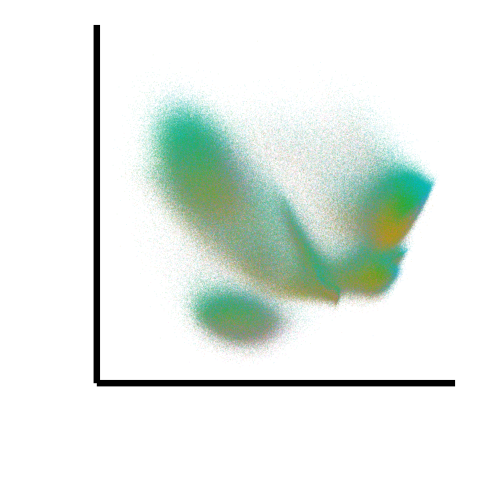

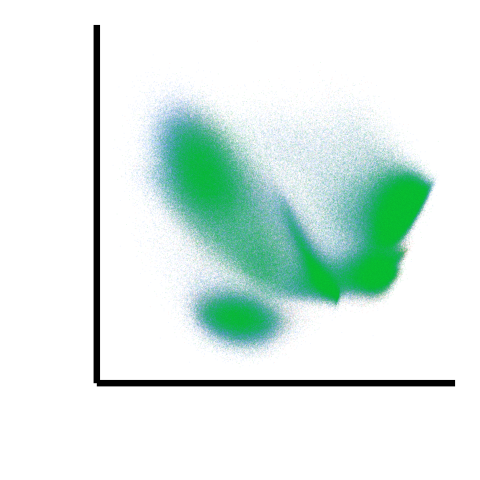

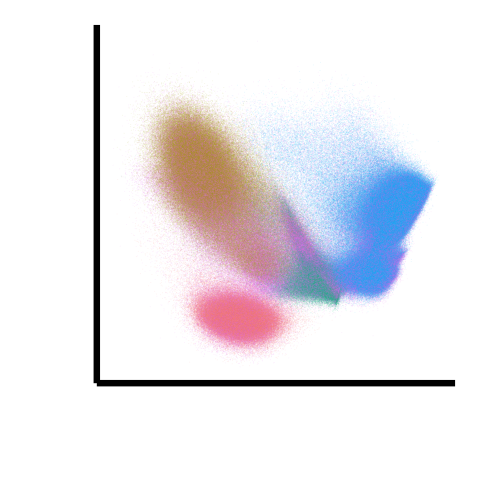

In [7]:
options(repr.plot.height = 4, repr.plot.width = 4)
ggplot() +
    geom_point(
        data = data.frame(pca_res$x[,c("PC1","PC2")],batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "batch"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

ggplot() +
    geom_point(
        data = data.frame(pca_res$x[,c("PC1","PC2")],batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "condition"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

ggplot() +
    geom_point(
        data = data.frame(pca_res$x[,c("PC1","PC2")],batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "cell"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

In [8]:
harmony_embeddings_all <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/harmony_embeddings_Prop",prop,"_Nmin",n_min,"_topVar",frac,".rds"))
batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/meta_Prop",prop,"_Nmin",n_min,".rds"))

In [9]:
print(head(harmony_embeddings_all))
print(dim(harmony_embeddings_all))

             PC1       PC2       PC3        PC4        PC5        PC6
[1,] -0.55021125 -1.403799 -2.404929 -1.1362646 -0.9935802 -0.5720085
[2,] -4.12623811  1.790525 -1.215055  0.6875451 -0.4918194  0.4919611
[3,]  1.01617600 -1.783511  0.321559  1.0505298  0.6036742  0.5272586
[4,] -0.59955783 -1.659248 -2.603984 -1.7878711 -0.6644482 -0.4876675
[5,] -0.08881486 -1.503106 -1.963201 -0.4862832 -1.0313271 -0.5827338
[6,]  1.58481342 -1.648941 -1.378232  2.0296782  1.0271875  0.5412468
             PC7         PC8         PC9       PC10
[1,]  0.06479768  0.22859965 -0.41083512 -0.1885381
[2,] -0.60581167  0.35535196  0.67926836  0.1357937
[3,]  0.30911672  0.50387096  0.51468704 -0.3106553
[4,]  0.51658492 -0.29656434 -0.42805927 -0.3218007
[5,] -0.66522762 -0.10032799 -0.07251168 -0.3523826
[6,]  1.12974223  0.09880806  0.03085324  1.1048964
[1] 2522140      10


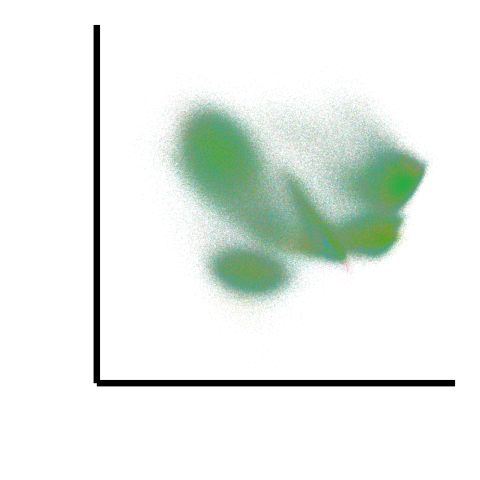

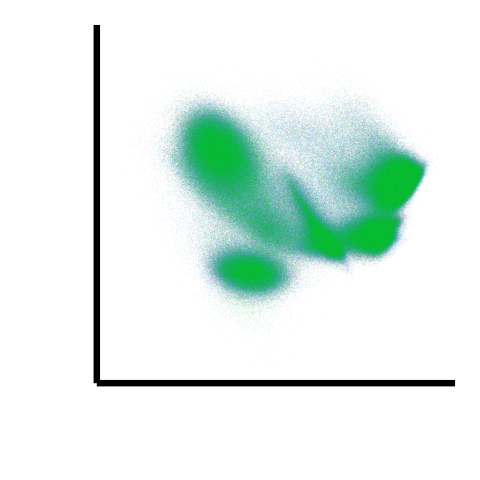

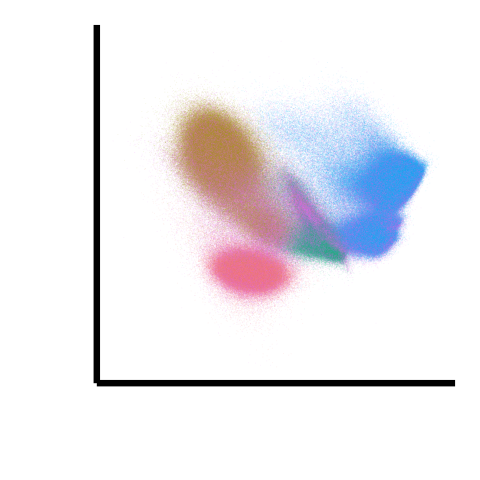

In [10]:

options(repr.plot.height = 4, repr.plot.width = 4)
ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all,batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "batch"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all,batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "condition"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )

# cell type
ggplot() +
    geom_point(
        data = data.frame(harmony_embeddings_all,batch_fl),
        mapping = aes_string(x = "PC1", y = "PC2", color = "cell"),
        size = 0.001, stroke = 0, shape = 16, alpha = 0.1
    ) +
    #scale_fill_manual(values = meta_colors$batch, name = "") +
   # facet_wrap( ~ batch, scales = "free") +
    labs(
        x = "",
        y = ""
    ) +
    theme_classic(base_size = 30) +
    theme(
        legend.position = "none",
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        panel.grid = element_blank(),
        plot.title = element_text(color="black", size=30, face = "italic")
    )


,key,val,group
,<chr>,<dbl>,<chr>
1,individual,16.54549,after
2,individual,17.77367,after
3,individual,16.56803,after
4,individual,14.73410,after
5,individual,13.84406,after
6,individual,16.48809,after


`summarise()` has grouped output by 'key'. You can override using the `.groups`
argument.


key,group,mean,median
<chr>,<chr>,<dbl>,<dbl>
Race,after,3.405448,3.272404
Race,before,3.377869,3.247132
Site,after,5.150714,5.116051
Site,before,5.073012,5.032645
batch,after,9.681282,9.717439
batch,before,8.725666,8.824727
cell,after,1.327284,1.075487
cell,before,1.327920,1.071367
condition,after,2.408134,2.432753


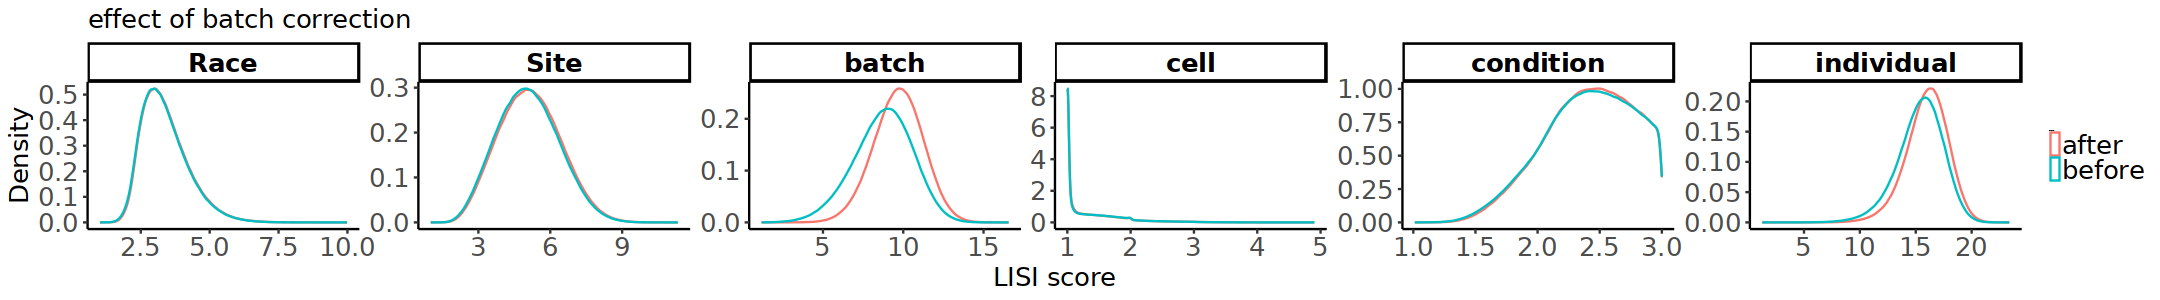

In [11]:
# check LISI score

LISI_df = rbind(
    readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/LISI_harmony_PC12.rds")) %>%
        dplyr::mutate(group = "after"),
    readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/LISI_PCA_PC12.rds")) %>%
        dplyr::mutate(group = "before")
    ) %>%
    dplyr::mutate(key = ifelse(key=="OmiqFileIndex", "individual", key))

head(LISI_df)

LISI_df %>%
    dplyr::group_by(key,group) %>%
    dplyr::summarize(mean = mean(val, na.rm = TRUE),median=median(val, na.rm = TRUE))

options(repr.plot.height = 2.5, repr.plot.width = 18)
ggplot(LISI_df) +
      geom_density(
        aes(x  = val, color = group) 
      ) +
      #   scale_x_continuous(limits = c(1, 15))+
      labs(
        title = "effect of batch correction",
        x = "LISI score",
        y = "Density"
      ) +
      facet_wrap( ~ key, scales = "free", ncol = 6) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "right",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0)) 

,key,val,group
,<chr>,<dbl>,<chr>
1,individual,8.473295,after
2,individual,7.316995,after
3,individual,11.557180,after
4,individual,9.292651,after
5,individual,10.638375,after
6,individual,9.494874,after


`summarise()` has grouped output by 'key'. You can override using the `.groups`
argument.


key,group,mean,median
<chr>,<chr>,<dbl>,<dbl>
Race,after,3.163106,3.016578
Race,before,3.127823,3.007518
Site,after,4.480186,4.452774
Site,before,4.322850,4.312323
batch,after,7.088139,7.155275
batch,before,5.532020,5.533013
cell,after,1.175501,1.000000
cell,before,1.144645,1.000000
condition,after,2.277389,2.293829


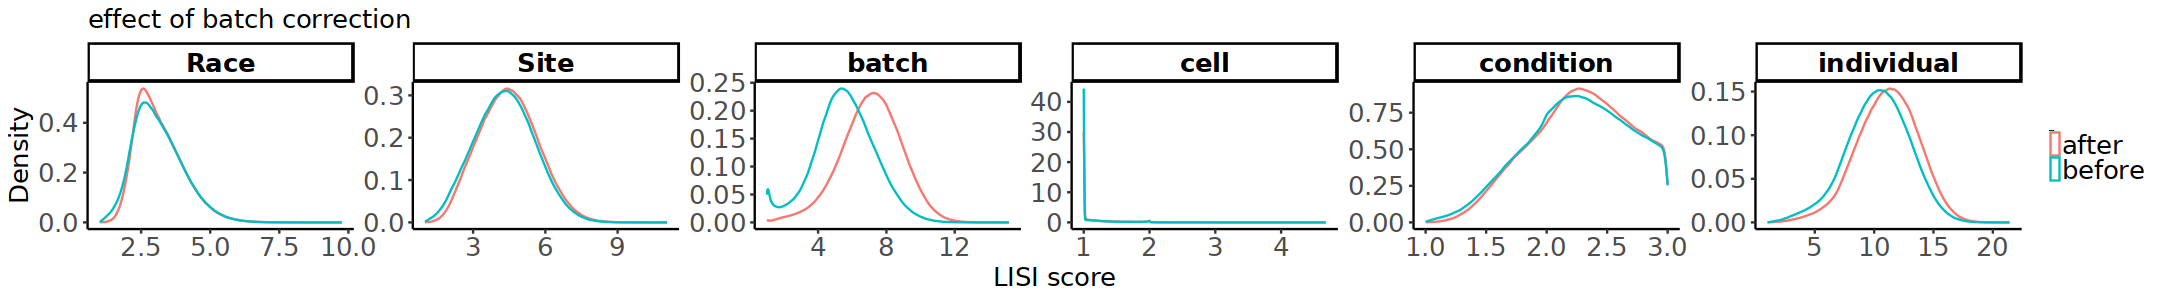

In [12]:

LISI_df = rbind(
    readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/LISI_harmony.rds")) %>%
        dplyr::mutate(group = "after"),
    readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/LISI_PCA.rds")) %>%
        dplyr::mutate(group = "before")
    ) %>%
    dplyr::mutate(key = ifelse(key=="OmiqFileIndex", "individual", key))

head(LISI_df)

LISI_df %>%
    dplyr::group_by(key,group) %>%
    dplyr::summarize(mean = mean(val, na.rm = TRUE),median=median(val, na.rm = TRUE))

options(repr.plot.height = 2.5, repr.plot.width = 18)
ggplot(LISI_df) +
      geom_density(
        aes(x  = val, color = group) 
      ) +
      #   scale_x_continuous(limits = c(1, 15))+
      labs(
        title = "effect of batch correction",
        x = "LISI score",
        y = "Density"
      ) +
      facet_wrap( ~ key, scales = "free", ncol = 6) +
      theme_classic() +
      theme(strip.text.x=element_text(size=15, color="black", face="bold"),
          strip.text.y=element_text(size=15, color="black", face="bold"),
          legend.position = "right",
          plot.title = element_text(size=15),
          axis.title.x = element_text(size=15),
          axis.title.y = element_text(size =15),
          axis.text.y = element_text(size = 15),
          axis.text.x = element_text(size = 15),
          legend.text =  element_text(size = 15),
          legend.key.size = grid::unit(0.5, "lines"),
          legend.title = element_text(size = 0.8, hjust = 0))

In [13]:
# UMAP visualization

umap_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
print(dim(umap_res))
print(head(umap_res))
print(table(umap_res$res_cell))

[1] 2522140       5
       UMAP1       UMAP2 disease batch res_cell
1  -6.461574  -7.5651316 Control    15        3
2 -10.887429   0.1934379 Control    15        0
3   2.589399 -11.1124229 Control    15        8
4  -7.032973  -7.1430731 Control    15        3
5  -4.934391  -7.5504570 Control    15        3
6   1.840085 -11.8443622 Control    15        2

     0      1     10     11     12     13     14     15     16     17      2 
371967 322212 139904  64020  44375  21548   1928   1895    108      1 300015 
     3      4      5      6      7      8      9 
239560 221078 180834 156729 154317 152703 148946 


In [14]:
# remove clusters less than cut off
min_cell_cluster = 30
clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
clu_logi = umap_res$res_cell %in% clu
print(dim(umap_res[clu_logi,]))
print(table(umap_res[clu_logi,]$res_cell))
print(length(unique(umap_res[clu_logi,]$res_cell)))
umap_res = umap_res[clu_logi,]

[1] 2522139       5

     0      1     10     11     12     13     14     15     16      2      3 
371967 322212 139904  64020  44375  21548   1928   1895    108 300015 239560 
     4      5      6      7      8      9 
221078 180834 156729 154317 152703 148946 
[1] 17


In [15]:
# Find cluster center
cluster_center <- umap_res %>%
  dplyr::group_by(res_cell) %>%
  dplyr::summarise_at(vars(UMAP1, UMAP2), dplyr::funs(median(., na.rm=TRUE)))
cluster_center <- as.data.frame(cluster_center)
cluster_center$res_cell <- as.character(cluster_center$res_cell)

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


In [16]:
# meta data

batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/meta_Prop",prop,"_Nmin",n_min,".rds"))
batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,2] %>% 
  stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
  as.data.frame() %>%
  .[,1] %>%
  gsub("-","_",.)
batch_fl = batch_fl[clu_logi,]
umap_res$subject_id = batch_fl$subject_id
umap_res$cell = batch_fl$cell
umap_res$time_point = batch_fl$time_point

meta<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta = merge(umap_res,meta,by="subject_id")
meta = meta[order(match(meta$subject_id, umap_res$subject_id)),]
all(meta$subject_id == umap_res$subject_id)

meta_add = read.table("/projects/jinamo@xsede.org/cytof/data/meta_clinical_RA.txt", header = TRUE, sep = "\t") %>%
  dplyr::mutate(CDAI = as.numeric(CDAI),
                subject_id = gsub("-","_",subject_id),
                treatment = dplyr::case_when(
                  treatment == "1" ~ "naive",
                  treatment == "2" ~ "MTX failure",
                  treatment == "3" ~ "TNF failure",
                  treatment == "4" ~ "OA"
                )) %>%
  dplyr::select(-c(sex))
meta_add = dplyr::left_join(umap_res,meta_add,by="subject_id")


umap_res$AtRisk = dplyr::case_when(
  meta$AMP_Group == "FDR" & meta$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  meta$AMP_Group == "GP" & meta$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  meta$AMP_Group == "FDR" & meta$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  meta$AMP_Group == "GP" & meta$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  umap_res$disease == "Control" ~ "Control",
  umap_res$disease == "RA" ~ "RA")
umap_res$AtRisk = factor(umap_res$AtRisk,levels=c("Control","FDR(-)/ACPA(-)","FDR(-)/ACPA(+)","FDR(+)/ACPA(-)","FDR(+)/ACPA(+)","RA"))
umap_res$disease = dplyr::case_when(
  umap_res$AtRisk == "FDR(+)/ACPA(+)" | umap_res$AtRisk == "FDR(-)/ACPA(+)" | umap_res$AtRisk == "FDR(+)/ACPA(-)" ~ "AtRiskRA",
  umap_res$AtRisk == "Control" | umap_res$AtRisk == "FDR(-)/ACPA(-)" ~ "Control",
  umap_res$AtRisk == "RA" ~ "RA")
umap_res$disease = factor(umap_res$disease,levels=c("Control","AtRiskRA","RA"))
umap_res$age_at_biopsy <- as.numeric(meta$age_at_biopsy)
umap_res$sex <- as.numeric(factor(meta$sex, c('female', 'male')))
umap_res$ethnicity <- as.numeric(factor(meta$ethnicity, c('not_hispanic', 'hispanic_latino')))
umap_res$AMP_Group <- as.numeric(factor(meta$AMP_Group, c('GP', 'FDR')))
umap_res$CCP <- as.numeric(factor(meta$CCP, c('Negative', 'Positive')))
umap_res$CCP30_titer <- as.numeric(meta$CCP30_titer)
umap_res$CCP31_titer <- as.numeric(meta$CCP31_titer)
umap_res$RF <- as.numeric(factor(meta$RF, c('Negative', 'Positive')))
umap_res$RF_IgM_titer <- as.numeric(meta$RF_IgM_titer)
umap_res$RF_IgG_titer <- as.numeric(meta$RF_IgG_titer)
umap_res$RF_IgA_titer <- as.numeric(meta$RF_IgA_titer)

head(umap_res)
table(umap_res$cell)
table(umap_res$time_point)
table(umap_res$AtRisk)
table(umap_res$disease)

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


[1] TRUE

,UMAP1,UMAP2,disease,batch,res_cell,subject_id,cell,time_point,AtRisk,age_at_biopsy,sex,ethnicity,AMP_Group,CCP,CCP30_titer,CCP31_titer,RF,RF_IgM_titer,RF_IgG_titer,RF_IgA_titer
,<dbl>,<dbl>,<fct>,<fct>,<chr>,<chr>,<chr>,<chr>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,-6.461574,-7.5651316,Control,15,3,200_0272,unknown,V0,Control,28,1,1,NA,NA,NA,NA,NA,NA,NA,NA
2,-10.887429,0.1934379,Control,15,0,200_0272,M,V0,Control,28,1,1,NA,NA,NA,NA,NA,NA,NA,NA
3,2.589399,-11.1124229,Control,15,8,200_0272,T,V0,Control,28,1,1,NA,NA,NA,NA,NA,NA,NA,NA
4,-7.032973,-7.1430731,Control,15,3,200_0272,unknown,V0,Control,28,1,1,NA,NA,NA,NA,NA,NA,NA,NA
5,-4.934391,-7.5504570,Control,15,3,200_0272,unknown,V0,Control,28,1,1,NA,NA,NA,NA,NA,NA,NA,NA
6,1.840085,-11.8443622,Control,15,2,200_0272,T,V0,Control,28,1,1,NA,NA,NA,NA,NA,NA,NA,NA



      B       M      NK       T unknown 
 151067  273130  129408 1087188  881346 


     V0      V1      V2 
1984281  274688  263170 


       Control FDR(-)/ACPA(-) FDR(-)/ACPA(+) FDR(+)/ACPA(-) FDR(+)/ACPA(+) 
        489449          86804         111168         288777         242686 
            RA 
       1303255 


 Control AtRiskRA       RA 
  576253   642631  1303255 

In [17]:
# remove doublet
double_clu = umap_res$res_cell == "15"
umap_res = umap_res[!double_clu,]
umap_res$res_cell = ifelse(umap_res$res_cell == "16", "15", umap_res$res_cell)

In [ ]:
get_density <- function(x, y, ...) {
  dens <- MASS::kde2d(x, y, ...)
  ix <- findInterval(x, dens$x)
  iy <- findInterval(y, dens$y)
  ii <- cbind(ix, iy)
  return(dens$z[ii])
}

umap_res = umap_res %>%
    dplyr::group_by(disease) %>%
    dplyr::mutate(density_disease = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(cell) %>%
    dplyr::mutate(density_cell = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(batch) %>%
    dplyr::mutate(density_batch = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(res_cell) %>%
    dplyr::mutate(density_cluster = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(AtRisk) %>%
    dplyr::mutate(density_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup() %>%
    dplyr::group_by(time_point,AtRisk) %>%
    dplyr::mutate(density_time_AtRisk = get_density(UMAP1, UMAP2, n = 100)) %>%
    dplyr::ungroup()

In [ ]:
options(repr.plot.height = 6, repr.plot.width = 5.5)
plot(ggplot() +
       geom_point(
         data = umap_res,
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "batch"),
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       scale_color_manual(values = c(
         "2" = "#4DAF4A",
         "3" = "#984EA3",
         "4" = "#FF7F00",
         "5" = "#FFFF33",
         "6" = "#A65628",
         "7" = "lightgrey",
         "8" = "#999999",
         "9" = "#66C2A5",
         "10" = "#67000D",
         "11" = "#8DA0CB",
         "12" = "#FFD92F",
         "13" = "#A6D854",
         "14" = "#E78AC3",
         "15" = "#FC8D62",
         "16" = "darkgrey",
         "17" = "#FEB24C",
         "18" = "#377EB8",
         "19" = "lightblue",
         "20" = "#FDE0EF",
         "21" = "#B8E186",
         "22" = "#66C2A5",
         "23" = "#E41A1C",
         "24" = "#377EB8")) +
       labs(
         title = paste0("UMAP by n_neighbors=",n_neighbors,"\nmin_dist=",min_dist,"\nClustering by resolution=",resolution_list,"\ncolored by batch"),
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "none",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=15, face = "italic")
       )
)

options(repr.plot.height = 12, repr.plot.width = 26)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_batch),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma", direction = -1, na.value = "black",limits = c(0, quantile(umap_res$density_batch, probs = seq(0, 1, 0.1))["90%"])) +
       facet_wrap( ~ batch, ncol = 8) +
       labs(
         title = paste0("UMAP by n_neighbors=",n_neighbors,"; min_dist=",min_dist,"; Clustering by resolution=",resolution_list,"\nby batch"),
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)
# dev.off()

options(repr.plot.height = 5, repr.plot.width = 15)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_disease),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma", direction = -1, 
                             # na.value = "black",
                             limits = c(0, quantile(umap_res$density_disease, probs = seq(0, 1, 0.01))["80%"])) +
       facet_wrap( ~ disease, ncol = 3) +
       labs(
         title = "",
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)


options(repr.plot.height = 5, repr.plot.width = 25)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_AtRisk),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma", direction = -1, na.value = "black",limits = c(0, quantile(umap_res$density_AtRisk, probs = seq(0, 1, 0.1))["90%"])) +
       facet_wrap( ~ AtRisk, ncol = 6) +
       labs(
         title = "",
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)

options(repr.plot.height = 6, repr.plot.width = 7.5)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/ALL/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_cluster.png"), width = 1400, height = 1400,res=360)
plot(ggplot() +
       geom_point(
         data = umap_res,
         mapping = aes_string(x = "UMAP1", y = "UMAP2", color = "cell"),
         size = 0.01, stroke = 0, shape = 16, alpha = 0.1
       ) +
       scale_color_manual(values = c(
                                    "T" = "#4DAF4A",
                                    "B" = "#984EA3",
                                    "NK" = "#FF7F00",
                                    "M" = "#FFFF33",
                                     "unknown" = "white")) +
       labs(
         x = "",
         y = "",
         title = ""
       ) +
       guides(colour = guide_legend(override.aes = list(size=10))) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )
)
# dev.off()

options(repr.plot.height = 5, repr.plot.width = 20)
# png(paste0("/projects/jinamo@xsede.org/cytof/results/T_cells/Clustering_neighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,"_batch.png"), width = 5000, height = 3000,res=360)
plot(ggplot(umap_res) +
       geom_point(aes(UMAP1, UMAP2, color = density_cell),
                  size = 1, stroke = 0, shape = 16) + 
       scale_color_viridis_c(option = "plasma", direction = -1, na.value = "black",limits = c(0, quantile(umap_res$density_cell, probs = seq(0, 1, 0.1))["90%"])) +
       facet_wrap( ~ cell, ncol = 5) +
       labs(
         title = "",
         x = "",
         y = ""
       ) +
       theme_classic(base_size = 30) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=30, face = "italic")
       )
)




In [ ]:
umap_res %>%
    dplyr::group_by(cell) %>%
    dplyr::summarize(count = dplyr::n())


In [ ]:
data.frame(subject_id = umap_res$subject_id, cluster = umap_res$res_cell, disease = umap_res$disease) %>%
          dplyr::mutate(cell = dplyr::case_when(
              cluster %in% c("1","5","6","7","9","10","14","15") ~ "CD4T",
              cluster %in% c("2","8") ~ "CD8T",
              cluster %in% c("0","11","12","13") ~ "M",
              cluster %in% c("4") ~ "B",
              cluster %in% c("3") ~ "NK")) %>%
          dplyr::group_by(disease,subject_id,cell) %>%
          dplyr::summarize(count = dplyr::n()) %>%
          dplyr::ungroup() %>%
          dplyr::group_by(subject_id) %>%
          dplyr::mutate(proportion = 100*count/sum(count)) %>%
          dplyr::ungroup() %>%
          dplyr::group_by(disease,cell) %>%
          dplyr::summarize(med = median(proportion)) %>%
          dplyr::arrange(cell,disease)

options(repr.plot.height = 4, repr.plot.width = 3)

for (clu in c("CD4T","CD8T","B","NK","M")){
    
    plot(
        data.frame(subject_id = umap_res$subject_id, cluster = umap_res$res_cell, disease = umap_res$disease) %>%
          dplyr::mutate(cell = dplyr::case_when(
              cluster %in% c("1","5","6","7","9","10","14","16") ~ "CD4T",
              cluster %in% c("2","8") ~ "CD8T",
              cluster %in% c("0","11","12","13") ~ "M",
              cluster %in% c("4") ~ "B",
              cluster %in% c("3") ~ "NK",
              cluster %in% c("15") ~ "unknown")) %>%
          dplyr::group_by(disease,subject_id,cell) %>%
          dplyr::summarize(count = dplyr::n()) %>%
          dplyr::ungroup() %>%
          dplyr::group_by(subject_id) %>%
          dplyr::mutate(proportion = 100*count/sum(count)) %>%
          dplyr::mutate(disease = factor(disease,levels = c("Control","AtRiskRA","RA"))) %>%
          dplyr::filter(cell==clu) %>%
          ggplot(., aes(x = disease, y=proportion)) + 
          geom_violin(aes(color = disease), fill = "white", scale = "width", draw_quantiles = c(0.25, 0.5, 0.75)) +
          geom_jitter(aes(fill = disease, color = disease)) +
          ggpubr::stat_compare_means(
            comparisons = list(c("Control", "AtRiskRA"), c("Control", "RA")), 
            label = "p.signif",
            tip.length = 0
            ) +
          scale_fill_manual(values=c("Control" = "grey75","AtRiskRA" = "orange","RA" = "red")) +
          scale_color_manual(values=c("Control" = "grey75","AtRiskRA" = "orange","RA" = "red")) + 
          theme_classic() +
          theme(strip.text.x=element_text(size=15, color="black", face="bold"),
                strip.text.y=element_text(size=15, color="black", face="bold"),
                legend.position = "none",
                plot.title = element_text(size=15),
                axis.title.x = element_text(size=15),
                axis.title.y = element_text(size =15),
                axis.text.y = element_text(size = 15),
                axis.text.x = element_text(size = 15, angle = 45, hjust=1),
                legend.text =  element_text(size = 15),
                legend.key.size = grid::unit(0.5, "lines"),
                legend.title = element_text(size = 0.8, hjust = 0)) +
          labs(title = clu,
               x = "",
               y = "") 

            )
}


In [ ]:
# CNA; covarying neighborhood analysis

In [ ]:
obj = readRDS(paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ALL/SeuratObj_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
obj@meta.data$subject_id <- stringr::str_split(obj@meta.data$OmiqFileIndex, pattern="_", simplify=TRUE)[,2] %>% 
                                    stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
                                    as.data.frame() %>%
                                    .[,1] %>%
                                    gsub("-","_",.)

umap_res <- readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/umap_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
# remove clusters less than cut off
min_cell_cluster = 30
clu = umap_res %>%
    dplyr::group_by(res_cell) %>%
    dplyr::summarize(count = dplyr::n()) %>%
    dplyr::arrange(count) %>%
    dplyr::filter(count > min_cell_cluster) %>%
    .$res_cell %>%
    unique()
clu_logi = umap_res$res_cell %in% clu
umap_res = umap_res[clu_logi,]

In [ ]:
# meta data

batch_fl = readRDS(file=paste0("/projects/jinamo@xsede.org/cytof/data/ALL/meta_Prop",prop,"_Nmin",n_min,".rds"))
batch_fl$subject_id <- stringr::str_split(batch_fl$OmiqFileIndex, pattern="_", simplify=TRUE)[,2] %>% 
  stringr::str_split(., pattern="\\-V", simplify=TRUE) %>%
  as.data.frame() %>%
  .[,1] %>%
  gsub("-","_",.)
batch_fl = batch_fl[clu_logi,]
umap_res$subject_id = batch_fl$subject_id
umap_res$time_point = batch_fl$time_point
all(umap_res$subject_id == obj@meta.data$subject_id)

meta<- read.table("/projects/jinamo@xsede.org/cytof/data/RA_AtRiskRA_Control_meta.txt",sep="\t",header=TRUE, na.strings=c("","NA")) %>%
    dplyr::mutate(age_at_biopsy = as.integer(age_at_biopsy),
                  diagnosis = factor(diagnosis, levels=c("Control","AtRiskRA","RA")))
meta = merge(meta,obj@meta.data,by="subject_id")
meta = meta[order(match(meta$subject_id, obj@meta.data$subject_id)),]
print(head(meta))
print(dim(meta))
table(meta$sex)
table(meta$ethnicity)
table(meta$sex)
table(meta$AMP_Group)
table(meta$CCP)
table(meta$RF)
all(meta$subject_id == obj@meta.data$subject_id)

meta_add = read.table("/projects/jinamo@xsede.org/cytof/data/meta_clinical_RA.txt", header = TRUE, sep = "\t") %>%
  dplyr::mutate(CDAI = as.numeric(CDAI),
                subject_id = gsub("-","_",subject_id),
                treatment = dplyr::case_when(
                  treatment == "1" ~ "naive",
                  treatment == "2" ~ "MTX failure",
                  treatment == "3" ~ "TNF failure",
                  treatment == "4" ~ "OA"
                )) %>%
  dplyr::select(-c(sex))
meta_add = dplyr::left_join(obj@meta.data[,!grepl("CDAI",colnames(obj@meta.data))],meta_add,by="subject_id")

meta_add2 = read.table("/projects/jinamo@xsede.org/cytof/data/clinical_data_for_FAN_from_Kat.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(-c(sex))
meta_add2 = dplyr::left_join(obj@meta.data[,!grepl("CDAI",colnames(obj@meta.data))],meta_add2,by="subject_id")

meta_add3 = read.table("/projects/jinamo@xsede.org/cytof/data/RA_Cleaned_aggregate_vars.txt", header = TRUE, sep = "\t") %>%
  dplyr::select(c(subject_id,HAQ,das28_crp3,bmi,ra_group,pathotype_str,sdai,ccp_type,ccp_range,rf_range,mdtjc28_sum,mdsjc28_sum,diabetes,Race_white,Race_black,Race_multiple,Race_other,MTX,SSZ,HCQ,LEF,TNFi))
meta_add3 = dplyr::left_join(obj@meta.data,meta_add3,by="subject_id")


In [ ]:

# merge meta data to Seurat object
obj@meta.data$AtRisk = dplyr::case_when(
  meta$AMP_Group == "FDR" & meta$CCP == "Positive" ~ "FDR(+)/ACPA(+)",
  meta$AMP_Group == "GP" & meta$CCP == "Positive" ~ "FDR(-)/ACPA(+)",
  meta$AMP_Group == "FDR" & meta$CCP == "Negative" ~ "FDR(+)/ACPA(-)",
  meta$AMP_Group == "GP" & meta$CCP == "Negative" ~ "FDR(-)/ACPA(-)",
  obj@meta.data$disease == "Control" ~ "Control",
  obj@meta.data$disease == "RA" ~ "RA")
obj@meta.data$age_at_biopsy <- as.numeric(meta$age_at_biopsy)
obj@meta.data$sex <- as.numeric(factor(meta$sex, c('female', 'male')))
obj@meta.data$ethnicity <- as.numeric(factor(meta$ethnicity, c('not_hispanic', 'hispanic_latino')))
obj@meta.data$AMP_Group <- as.numeric(factor(meta$AMP_Group, c('GP', 'FDR')))
obj@meta.data$CCP <- as.numeric(factor(meta$CCP, c('Negative', 'Positive')))
obj@meta.data$CCP30_titer <- as.numeric(meta$CCP30_titer)
obj@meta.data$CCP31_titer <- as.numeric(meta$CCP31_titer)
obj@meta.data$RF <- as.numeric(factor(meta$RF, c('Negative', 'Positive')))
obj@meta.data$RF_IgM_titer <- as.numeric(meta$RF_IgM_titer)
obj@meta.data$RF_IgG_titer <- as.numeric(meta$RF_IgG_titer)
obj@meta.data$RF_IgA_titer <- as.numeric(meta$RF_IgA_titer)
obj@meta.data$batch <- as.numeric(factor(meta$batch))
obj@meta.data$AtRisk = factor(obj@meta.data$AtRisk,levels=c("Control","FDR(+)/ACPA(+)","FDR(-)/ACPA(+)","FDR(+)/ACPA(-)","FDR(-)/ACPA(-)","RA"))
obj@meta.data$alt_AtRisk = dplyr::case_when(
  obj@meta.data$AtRisk == "FDR(-)/ACPA(-)" ~ "FDR(-)/ACPA(-)",
  obj@meta.data$AtRisk == "FDR(+)/ACPA(-)" | obj@meta.data$AtRisk == "FDR(-)/ACPA(+)" | obj@meta.data$AtRisk == "FDR(+)/ACPA(+)" ~ "AtRiskRA",
  TRUE ~ "others")
obj@meta.data$ctap <- dplyr::case_when(
  meta$diagnosis == "AtRiskRA" ~ "AtRiskRA",
  meta$diagnosis == "Control" ~ "Control")
obj@meta.data$ctap <- ifelse(is.na(obj@meta.data$ctap),meta$ctap,obj@meta.data$ctap)
obj@meta.data$CDAI <- as.numeric(meta_add$CDAI)
obj@meta.data$krenn_lining <- as.numeric(meta_add$krenn_lining)
obj@meta.data$krenn_inflammation <- as.numeric(meta_add$krenn_inflammation)
obj@meta.data$treatment <- dplyr::case_when(
  meta$diagnosis == "AtRiskRA" ~ "AtRiskRA",
  meta$diagnosis == "Control" ~ "Control")
obj@meta.data$treatment <- ifelse(is.na(obj@meta.data$treatment),meta_add$treatment,obj@meta.data$treatment)
obj@meta.data$disease = dplyr::case_when(
  obj@meta.data$AtRisk == "FDR(+)/ACPA(+)" | obj@meta.data$AtRisk == "FDR(-)/ACPA(+)" | obj@meta.data$AtRisk == "FDR(+)/ACPA(-)" ~ "AtRiskRA",
  obj@meta.data$AtRisk == "Control" | obj@meta.data$AtRisk == "FDR(-)/ACPA(-)" ~ "Control",
  obj@meta.data$AtRisk == "RA" ~ "RA")
obj@meta.data$condition = obj@meta.data$disease
obj@meta.data$condition = factor(obj@meta.data$condition, levels = c('Control', 'AtRiskRA', "RA"))

obj@meta.data$CRP <- as.numeric(meta_add2$crp_result)
obj@meta.data$ESR <- as.numeric(meta_add2$esr_result)
obj@meta.data$RA_duration_years <- as.numeric(meta_add2$RA_duration_years)
obj@meta.data$CDAI <- ifelse(is.na(obj@meta.data$CDAI), as.numeric(meta_add2$cdai), obj@meta.data$CDAI)
obj@meta.data$SDAI <- as.numeric(meta_add3$sdai)
obj@meta.data$DAS28_ESR <- as.numeric(meta_add2$das28_esr3)
obj@meta.data$DAS28_CRP <- as.numeric(meta_add3$das28_crp3)
obj@meta.data$CCP31_titer <- ifelse(obj@meta.data$condition == "RA", as.numeric(meta_add2$ccp_result), obj@meta.data$CCP31_titer)
obj@meta.data$CCP31_cutoff <- as.numeric(meta_add3$ccp_range)
obj@meta.data$RF_IgM_titer <- ifelse(obj@meta.data$condition == "RA", as.numeric(meta_add2$rf_result), obj@meta.data$RF_IgM_titer)
obj@meta.data$RF_IgM_cutoff <- as.numeric(meta_add3$rf_range)
obj@meta.data$smoke_hx <- as.factor(meta_add2$smoke_hx)
obj@meta.data$smoke_current <- as.factor(meta_add2$smoke_current)
obj@meta.data$Methotrexate_only <- meta_add2$Methotrexate_only
obj@meta.data$TNFi_possible_nbDMARD <- meta_add2$TNFi_possible_nbDMARD
obj@meta.data$other_bDMARD <- meta_add2$other_bDMARD
obj@meta.data$other_nbDMARD_no_bDMARD <- meta_add2$other_nbDMARD_no_bDMARD
obj@meta.data$no_DMARD <- meta_add2$no_DMARD
obj@meta.data$bDMARD <- meta_add2$bDMARD
obj@meta.data$nbDMARD <- meta_add2$nbDMARD
obj@meta.data$Prednisone <- meta_add2$Prednisone
obj@meta.data$Prednisone_GE_7.5 <- ifelse(obj@meta.data$Prednisone, meta_add2$Prednisone_GE_7.5, FALSE)

obj@meta.data$time_point <- batch_fl$time_point

In [ ]:
# Control vs AtRiskRA 

In [ ]:
logi = obj$condition %in% c("Control","AtRiskRA")
obj_sub = readRDS(paste0("/pl/active/fanzhanglab/jinamo/cytof/data/ALL/SeuratObj_Control_AtRiskRA_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))


In [ ]:
# positive correlation means association with at-risk RA
options(repr.plot.height = 6, repr.plot.width = 8)
cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs)) %>%
    dplyr::mutate(trans = abs(cna_ncorrs)*2) %>%
    ggplot(aes(x = UMAP1, y = UMAP2)) +
       geom_point(
         aes(color = cna_ncorrs, alpha = trans),
           size = 0.001, stroke = 0, shape = 16
       ) +
       scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab" ) +
       labs(
         x = "UMAP1",
         y = "UMAP2",
         title = 'CNA disease association\n[control VS at-risk RA]', 
         color = 'Correlation',
         subtitle = sprintf('global p=%0.3f', obj_sub@reductions$cna@misc$p)
       ) +
       theme_bw(base_size = 20) +
       theme(
         legend.position = "right",
         axis.text = element_blank(),
         axis.ticks = element_blank(),
         panel.grid = element_blank(),
         plot.title = element_text(color="black", size=20)
       )


In [ ]:
cor_pos = obj_sub@meta.data$cna_ncorrs_fdr05
cor_pos = cor_pos[cor_pos > 0]
# summary(cor_pos)
cor_neg = obj_sub@meta.data$cna_ncorrs_fdr05
cor_neg = cor_neg[cor_neg < 0]
# summary(cor_neg)

ord = cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
          dplyr::mutate(cell = dplyr::case_when(
                  res_cell %in% c("1","5","6","7","9","10","14","16") ~ "CD4T",
                  res_cell %in% c("2","8") ~ "CD8T",
                  res_cell %in% c("0","11","12","13") ~ "M",
                  res_cell %in% c("4") ~ "B",
                  res_cell %in% c("3") ~ "NK",
                  res_cell %in% c("15") ~ "unknown")) %>%
  dplyr::filter(cell %in% c("CD4T","CD8T","M","B","NK")) %>%
    dplyr::group_by(cell) %>%
    dplyr::summarize(med = median(cna_ncorrs)) %>%
    dplyr::arrange(med) %>%
    .$cell

p <- cbind(umap_res[logi,],obj_sub@meta.data) %>%
    dplyr::select(c(UMAP1,UMAP2,cna_ncorrs,res_cell)) %>%
          dplyr::mutate(cell = dplyr::case_when(
                  res_cell %in% c("1","5","6","7","9","10","14","16") ~ "CD4T",
                  res_cell %in% c("2","8") ~ "CD8T",
                  res_cell %in% c("0","11","12","13") ~ "M",
                  res_cell %in% c("4") ~ "B",
                  res_cell %in% c("3") ~ "NK",
                  res_cell %in% c("15") ~ "unknown")) %>%
  dplyr::filter(cell %in% c("CD4T","CD8T","M","B","NK")) %>%
    dplyr::mutate(cell = factor(cell,levels=ord)) %>%
    ggplot(aes(x=cell, y=cna_ncorrs)) + 
    geom_violin(trim=TRUE, scale = "width")

mywidth <- .35 # bit of trial and error
# This is all you need for the fill: 
vl_fill <- data.frame(ggplot_build(p)$data) %>%
  mutate(xnew = x- mywidth*violinwidth, xend = x+ mywidth*violinwidth) 

# Bit convoluted for the outline, need to be rearranged: the order matters
vl_poly <- 
  vl_fill %>% 
  select(xnew, xend, y, group) %>%
  pivot_longer(-c(y, group), names_to = "oldx", values_to = "x") %>% 
  arrange(y) %>%
  split(., .$oldx) %>%
  map(., function(x) {
    if(all(x$oldx == "xnew")) x <- arrange(x, desc(y))
    x
    }) %>%
  bind_rows()


if (length(cor_pos)!=0 & length(cor_neg)!=0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_pos), max(cor_neg)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +   
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =12, angle = 25, hjust = 1),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)!=0 & length(cor_neg)==0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_pos)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =12, angle = 25, hjust = 1),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)==0 & length(cor_neg)!=0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        # geom_hline(yintercept=c(min(cor_neg)), linetype='dashed', color='black') +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =12, angle = 25, hjust = 1),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  } else if (length(cor_pos)==0 & length(cor_neg)==0) {
      g1 = ggplot() +
        geom_polygon(data = vl_poly, aes(x, y, group = group), size = 1, fill = NA) +  
        geom_segment(data = vl_fill, aes(x = xnew, xend = xend, y = y, yend = y, color = y)) +
        scale_color_gradient2(midpoint = 0, low = '#3C5488FF', mid = "white", high = '#DC0000FF', space = "Lab") +
        scale_x_continuous(labels=ord, breaks=1:length(unique(ord)) , limits=c(min(vl_poly$x),max(vl_poly$x))) +
        geom_hline(yintercept=0, linetype='dashed', color='black') +
        theme_classic() +
        coord_flip() +
        theme(strip.text.x=element_text(size=15, color="black", face="bold"),
              strip.text.y=element_text(size=15, color="black", face="bold"),
              legend.position = "none",
              plot.title = element_text(size=15),
              axis.title.x = element_text(size=15),
              axis.title.y = element_text(size =15),
              axis.text.y = element_blank(),
              axis.text.x = element_text(size =12, angle = 25, hjust = 1),
              legend.text =  element_text(size = 15),
              legend.key.size = grid::unit(0.5, "lines"),
              legend.title = element_text(size = 0.8, hjust = 0)) +
        labs(title = "",
             x = "",
             y = "Neighborhood\nCorrelation") 
  }


# MASC: Mixed-effects association testing for single cells
## Sci Transl Med. 2018 Oct 17;10(463):eaaq0305.

masc = readRDS(file = paste0("/projects/jinamo@xsede.org/cytof/data/ALL/MASC_Control_AtRiskRA_CellTypes_Prop",prop,"_Nmin",n_min,"_topVar",frac,"_nneighbors",n_neighbors,"_mindist",min_dist,"_res",resolution_list,".rds"))
masc
g2 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
    dplyr::mutate(col = dplyr::case_when(
      CIupper < 1 ~ '#3C5488FF',
      CIlower > 1 ~ '#DC0000FF',
      TRUE ~ "lightgray"),
                 CIupper = ifelse(CIupper>100 & model.pvalue>0.05, 1, CIupper),
                 CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
                 OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cell = gsub("cluster","",cluster),
                cell = factor(cell,levels=ord)) %>%
  ggplot(., aes(y=cell, x=OR, colour=col)) + 
  geom_point(position=position_dodge(width=0.3), size=3) +
  geom_errorbarh(aes(xmin=CIlower, xmax=CIupper), position = position_dodge(0.3), height=0.5, linewidth = 1) +
  scale_color_manual(values = c('#3C5488FF' = '#3C5488FF', '#DC0000FF' = '#DC0000FF', "lightgray" = "lightgray")) + 
  geom_vline(xintercept=1, linetype='dashed', color='black') +
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_blank(),
        axis.text.x = element_text(size = 12, angle = 25, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "log(OR)")

g3 = masc %>%
  magrittr::set_colnames(c("cluster","size","model.pvalue","OR","CIlower","CIupper")) %>%
    dplyr::mutate(col = dplyr::case_when(
      CIupper < 1 ~ '#3C5488FF',
      CIlower > 1 ~ '#DC0000FF',
      TRUE ~ "lightgray"),
                 CIupper = ifelse(CIupper>100 & model.pvalue>0.05, 1, CIupper),
                 CIlower = ifelse(CIlower<0.01 & model.pvalue>0.05, 1, CIlower),
                 OR = ifelse(CIupper==1|CIlower==1,1,OR)) %>%
  dplyr::mutate(cell = gsub("cluster","",cluster),
                cell = factor(cell,levels=ord)) %>%
  ggplot(., aes(y=cell, x=size)) + 
  geom_bar(stat = "identity", position=position_dodge()) + 
  theme_classic() +
  theme(strip.text.x=element_text(size=15, color="black", face="bold"),
        strip.text.y=element_text(size=15, color="black", face="bold"),
        legend.position = "none",
        plot.title = element_text(size=15),
        axis.title.x = element_text(size=15),
        axis.title.y = element_text(size =15),
        axis.text.y = element_text(size = 15),
        axis.text.x = element_text(size = 12, angle = 25, hjust = 1),
        legend.text =  element_text(size = 15),
        legend.key.size = grid::unit(0.5, "lines"),
        legend.title = element_text(size = 0.8, hjust = 0)) +
  labs(title = "",
       y = "",
       x = "analyzed\ncells")
options(repr.plot.height = 3, repr.plot.width = 5.5)
(g3+g2+g1)+plot_layout(widths = c(0.7,1,1))
